In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import tensorflow as tf
import numpy as np
import random
from tensorflow import keras
from tensorflow.keras import utils as np_utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout, BatchNormalization, Softmax
from tensorflow.keras import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
import datetime
from time import time
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.layers.pooling import GlobalAveragePooling2D

import sys
sys.path.append("/home/ecbm4040/Final_Project/e4040-2021Fall-Project-SCNN-as6430-as6456-vsk2123/src/")

In [5]:
# Load and prepare data

# CIFAR10 Dataset
from modules.utils import load_data
X_train, y_train = load_data(mode='train')
num_training = 49000
num_validation = 1000

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data, and reshape it to be RGB size
mean_image = np.mean(X_train, axis=0)
X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image

X_train = X_train.reshape(-1,3,32,32).transpose(0,2,3,1) / 255
X_val = X_val.reshape(-1,3,32,32).transpose(0,2,3,1) / 255

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)

y_train_dummy = tf.keras.utils.to_categorical(y_train)
y_val_dummy = tf.keras.utils.to_categorical(y_val)
print('Train labels shape (one-hot): ', y_train_dummy.shape)
print('Validation labels shape (one-hot): ', y_val_dummy.shape)



./data/cifar-10-python.tar.gz already exists. Begin extracting...
Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Train labels shape (one-hot):  (49000, 10)
Validation labels shape (one-hot):  (1000, 10)


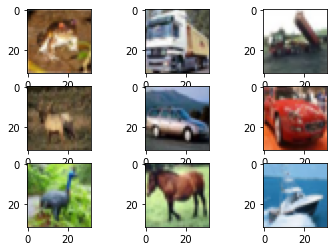

In [3]:
# Plot sample images before augmentation
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i])
plt.show()

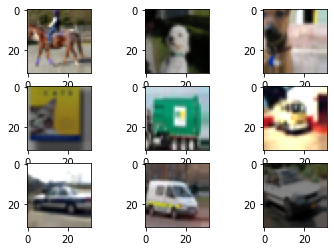

In [4]:
# Data augmentation code

def HSV_perturbations(image):
    """
    Takes an input image and returns it with either the randomly adjusted hue or saturation
    (or may be makes no HSV change at all) with a probability of 1/3
    """
    choice=random.randint(1,3)
    print(choice)
    image = np.array(image)
    if choice ==1:
        return tf.image.random_hue(image, 1/random.randint(1,10))
    elif choice ==2:
        return tf.image.random_saturation(image, 5, 10)
    else:
        return image # so as to avoid not change hue for every image

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.5,1.5]
    )
datagen.fit(x_train)

# Plot sample augmented images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].astype(np.uint8))
    plt.show()
    break

In [5]:
from google.colab import drive
drive.flush_and_unmount
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [18]:
# Creating Spectral CNN Layer
class SpectralConvolution2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size,strides,padding,**kwargs):
        self.no_of_kernels = filters
        self.kernel_shape = kernel_size
        self.strides=strides
        if padding =="same":
            self.padding=kernel_size[0]-1
        else:
            self.padding=0
        super(SpectralConvolution2D, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=self.kernel_shape + (input_shape[-1], self.no_of_kernels),# (k_width,k_height,input channels, # kernels) (3,3,3,32) 
                             initializer='random_normal',
                             trainable=True)
        self.bias = self.add_weight(shape=(self.no_of_kernels,),# 1 bias for each kernel
                             initializer='random_normal',
                             trainable=True)


        super(SpectralConvolution2D, self).build(input_shape)

    def call(self, inputs):

        out_shape = (inputs.get_shape().as_list()[1] - self.kernel.get_shape().as_list()[0] + self.padding)//self.strides[0] + 1
        spatial_inputs = tf.transpose(inputs, perm=[0,3,1,2]) 
        spatial_kernel = tf.transpose(self.kernel, perm=[3,2,0,1]) 
        # Converting the inputs and kernel into spectral domain
        spectral_inputs = tf.signal.rfft2d(spatial_inputs, [out_shape, out_shape])
        spectral_kernel = tf.signal.rfft2d(spatial_kernel, [out_shape, out_shape])
        # Convolution in the spectral domain
        spectral_convolution_output = tf.einsum('imkl,jmkl->ijkl', spectral_inputs, spectral_kernel)
        # Converting the output in spectral domain back to spatial domain
        spatial_convolution_output = tf.signal.irfft2d(spectral_convolution_output, [out_shape, out_shape])
        spatial_convolution_output = tf.transpose(spatial_convolution_output, perm=[0,2,3,1])
        spatial_convolution_output = tf.nn.bias_add(spatial_convolution_output, self.bias)
        return spatial_convolution_output 


In [19]:
# Generic CNN architecture  
def spectralConvolutionCNN():
    model = Sequential()

    model.add(SpectralConvolution2D(96, kernel_size=(5,5),padding="same", strides=(1,1), input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))

    model.add(SpectralConvolution2D(192, kernel_size=(5,5),padding="same",strides=(1,1)))
    model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(1024))
    model.add(Dense(512))
    model.add(Dense(output_size, activation='softmax')) 


    return model
  

In [ ]:
# Compiling and training the model
batch_size=128
nb_epochs=50

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
valid_generator = datagen.flow(x_test, y_test, batch_size=batch_size)


spectral_cnn_model = spectralConvolutionCNN()
spectral_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history=spectral_cnn_model.fit_generator(train_generator,epochs=nb_epochs,steps_per_epoch=len(x_train)//batch_size, validation_data=valid_generator)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
390/390 [==============================] - 73s 177ms/step - loss: 593.4733 - accuracy: 0.3949 - val_loss: 27.7353 - val_accuracy: 0.4552
Epoch 2/50
390/390 [==============================] - 64s 164ms/step - loss: 18.6581 - accuracy: 0.4816 - val_loss: 11.6244 - val_accuracy: 0.4933
Epoch 3/50
390/390 [==============================] - 64s 163ms/step - loss: 7.9663 - accuracy: 0.5078 - val_loss: 5.8926 - val_accuracy: 0.4928
Epoch 4/50
390/390 [==============================] - 64s 163ms/step - loss: 3.7172 - accuracy: 0.5226 - val_loss: 2.8553 - val_accuracy: 0.5172
Epoch 5/50
390/390 [==============================] - 63s 162ms/step - loss: 2.2734 - accuracy: 0.5258 - val_loss: 2.0529 - val_accuracy: 0.5279
Epoch 6/50
390/390 [==============================] - 63s 162ms/step - loss: 2.0484 - accuracy: 0.5274 - val_loss: 2.1913 - val_accuracy: 0.4926
Epoch 7/50
390/390 [==============================] - 63s 162ms/step - loss: 2.1542 - accuracy: 0.5204 - val_loss: 2.2011 - v